# Tennis Player - Image Classifier

## Intro to Data Mining - Final Project

## Daniel Bernal


### Fall 2022

**Problem and Motivation**

As a passionate for the sport of tennis, I decided to apply some of the methods studied in class to generate a model for image classification for my favorite tennis players. To be able to accomplish this, I explored several online resources and code examples in order to achieve the end goal, and end up with a model that will allow me to classify images, and most importantly, expand my repertoire of machine learning projects. It is important to mention that my initial idea for this project was different but due to the data collection contraints, it was not possible to acoomplish it given the short period of time. 


**Related Work**

I found a variety of machine learning applications to image classification, but the main differences is how the data is collected and processed. For example, some use already collected data, while others use download tools such as `googleimagesdownload`. To the best of my knowledge, there has not been a project involving this specific data, meaning that it is unique, but there other approaches that use similar tools and models to accomplish image classification tasks.


**Data** 

To train a supervised model, it is required to have a ground truth, that is, assigning labels to each class of image that we have. Furthermore, to create a robust model, it is required to have several data points. The collection of data for this project was done through google download using the extension `fatkun`. It allows you to download several images for a particular topic, example: Maria Sharapova. It will search all images and name them according to the title of the source. 
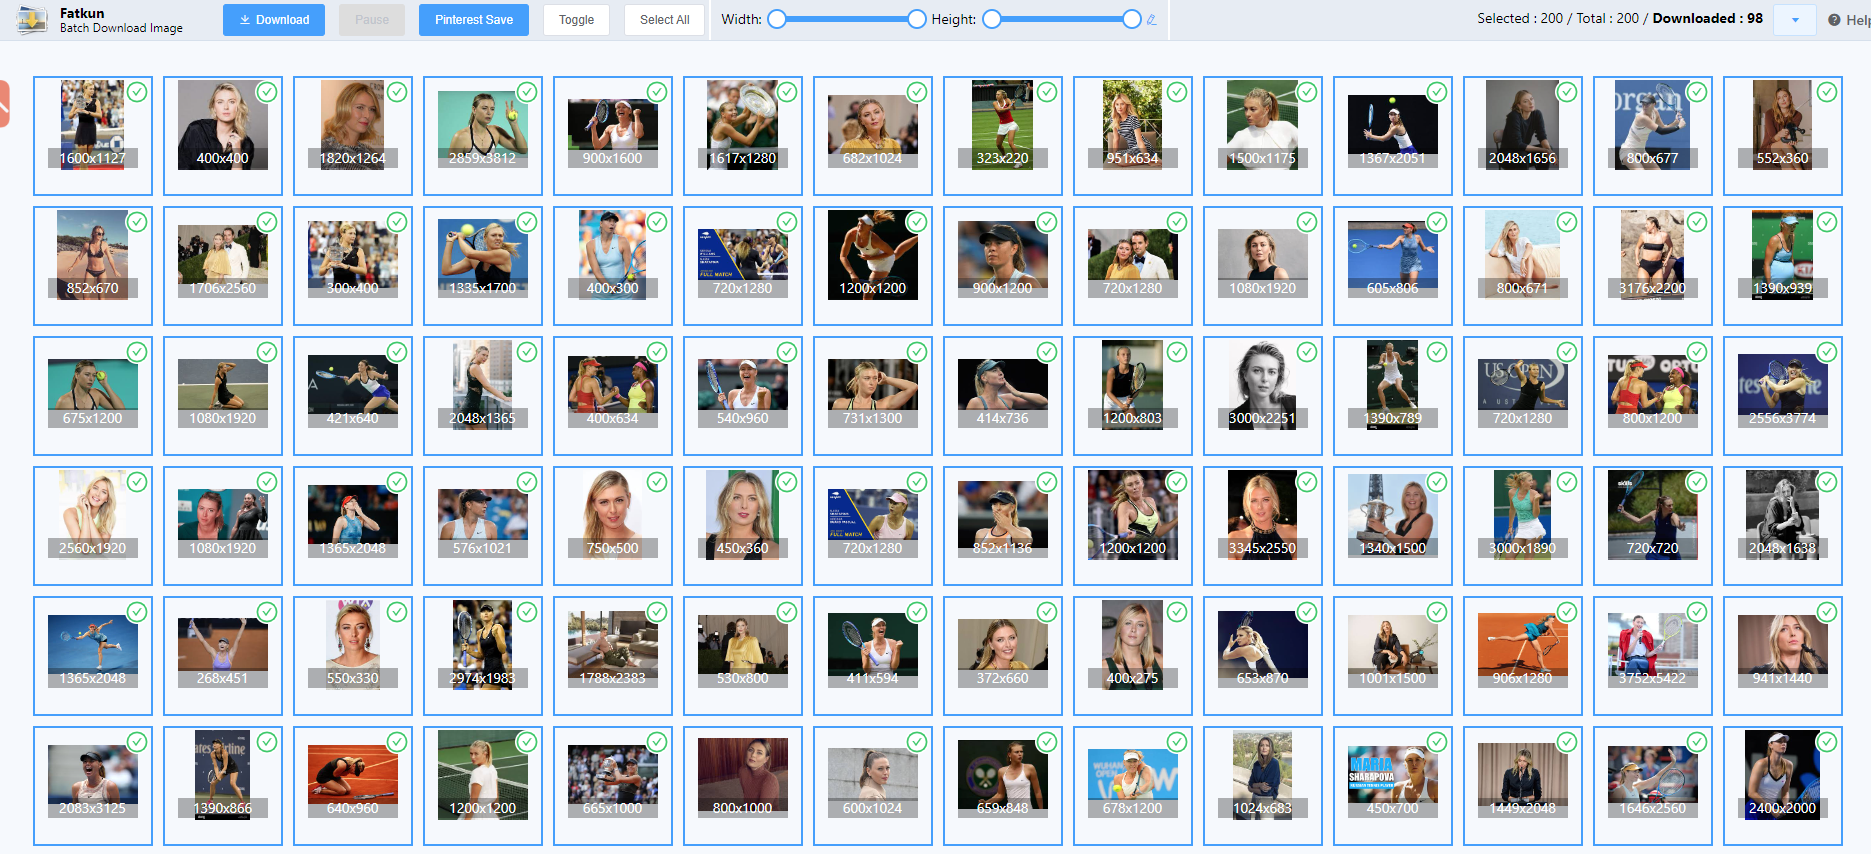



**Importing Relevant Libraries**

In [327]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import pywt
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import seaborn as sn
import os
import shutil
import pandas as pd
from sklearn.metrics import confusion_matrix



%matplotlib inline

**Approach**

To be able to explain the approach that this project took, I decided to illustrate it with a test image of one of the tennis players. Here we have Maria Sharapova and we have read the image with the library called `cv2` which the import name for `opencv`. It is a python library that it is used for image processing and for performing computer vision tasks. 

In [328]:
img = cv2.imread('./test_images/sharapova1.jpg') #Reading an image using opencv
img.shape #Three dimensions: x,y,rgb

(450, 360, 3)

Showing out first sample image

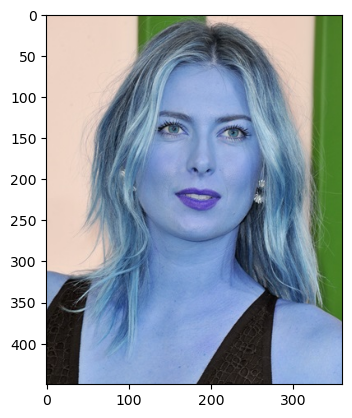

In [329]:
plt.imshow(img)

`opencv` also allows us to change it to a gray image, this will remove the third dimension `rgb`. 

In [330]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(450, 360)

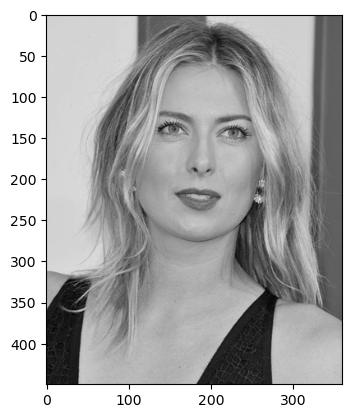

In [287]:
plt.imshow(gray, cmap='gray')

One of they key aspects of effective image classification for humans, it is the ability to identify face features such as nose, or eyes. To do so, I also used some tools provided by `opencv` that are called [Haar Cascades](url_here). This method was proposed by Paul Viola and Michael Jones in their paper "Rapic Object Detection Using a Boosted Cascade of Simple Features" in 2001. This is an approach where the cascade function is trained from a lot of positive and negative images, and then used to detect objects in other images.

Additionally, `opencv` provides the documentation and the code so it allows any user to implement it very easily. 

In [331]:
# Downloading and running the algorithms to detect face and nose
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

Now, using the `face_cascadeMultiScale` function we will now pass our previously created image called `gray` and will return a array of values that represent x, y, width, and height. 

In [332]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[100,  71, 179, 179]])

Now if we want to illustrate this, we can save the array into four different objects.

In [334]:
(x,y,w,h) = faces[0]
x,y,w,h

(100, 71, 179, 179)

Using `cv2.rectangle`, we are able to generate a rectangle and illustrate it in our original test image `img` to see if the algorithm actually detected the face of Maria Sharapova.

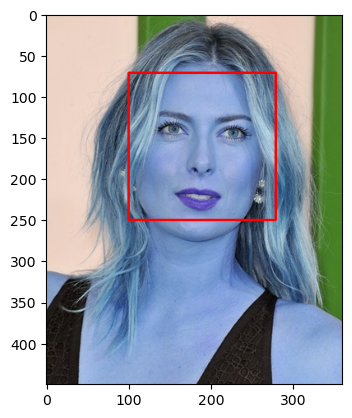

In [335]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) #Rectangle in red color
plt.imshow(face_img)

Now what we want to do is to integrate the detection od the eyes and faces. I noticed that in some images there are multiple faces, since these are just random. so we want to identify all faces and all eyes in the case where two or more faces are present. To do so, we will do a for loop and integrate the code created above where we generated the red rectangle to identify the face, plus the algorithm fo the eyes (rectangle with green color (0,255,0)).

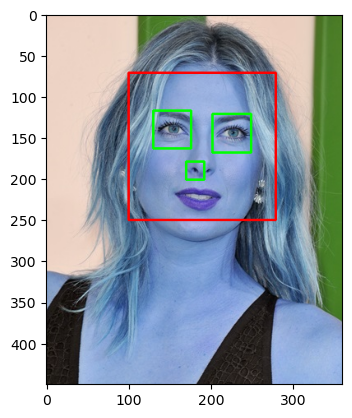

In [336]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w] #This represents only the region for the rectangle of the face.
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

Plotting only the rectangle of the face.

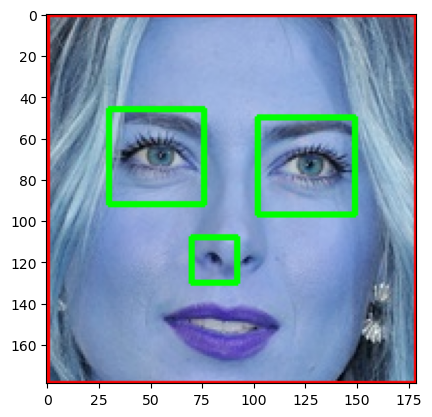

In [292]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

Given the we have already generated a cropped sample image, now we need to do it for all of the images that we downloaded, and to do so, we will use a function that will allow us to do so.

In [337]:
def get_cropped(image_path):
    img = cv2.imread(image_path) # Generating the image path
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Removing the third dimension
    faces = face_cascade.detectMultiScale(gray, 1.3, 5) #Identifying the array for the rectangle coordinates
    for (x,y,w,h) in faces:  #Re-using cvode created previously
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

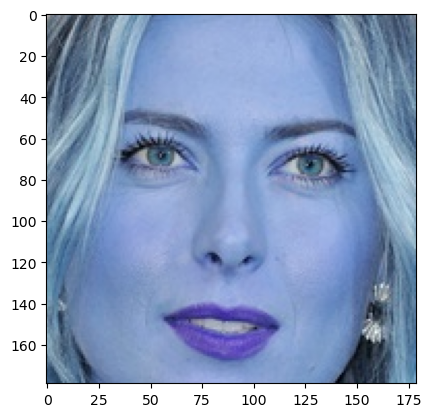

In [339]:
cropped_image = get_cropped('./test_images/sharapova1.jpg')
plt.imshow(cropped_image)

Let's try another example to see if our function works.

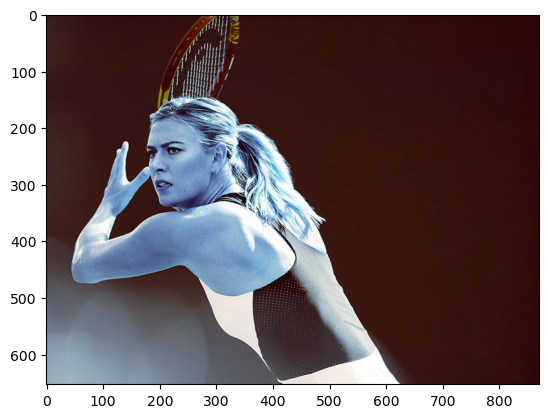

In [340]:
org_image_obs = cv2.imread('./test_images/sharapova2.jpg')
plt.imshow(org_image_obs)

No output since the algorithm was not able to detect a face or eyes, this will allow us to only crop the images that will be useful for our classification model. 

In [342]:
cropped_image_no_2_eyes = get_cropped('./test_images/sharapova2.jpg')
cropped_image_no_2_eyes

Now we want to utilize our function to generate our data with cropped images.

In [299]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [300]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [301]:
img_dirs 

['./dataset/cropped',
 './dataset/maria_sharapova',
 './dataset/novak_djokovic',
 './dataset/rafael_nadal',
 './dataset/roger_federer',
 './dataset/serena_williams']

Generating the cropped folder if it doesn't exist, toherwise, it will overwrite it.

In [302]:
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data) 

In [303]:
img_dirs

['./dataset/cropped',
 './dataset/maria_sharapova',
 './dataset/novak_djokovic',
 './dataset/rafael_nadal',
 './dataset/roger_federer',
 './dataset/serena_williams']

Iterate to create a cropped copy for each image if it is applicable

In [304]:
cropped_image_dirs = [] # Cropped folder path for each tennis player
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1    


cropped
maria_sharapova
Generating cropped images in folder:  ./dataset/cropped/maria_sharapova
novak_djokovic
Generating cropped images in folder:  ./dataset/cropped/novak_djokovic
rafael_nadal
Generating cropped images in folder:  ./dataset/cropped/rafael_nadal
roger_federer
Generating cropped images in folder:  ./dataset/cropped/roger_federer
serena_williams
Generating cropped images in folder:  ./dataset/cropped/serena_williams


Now that I have created my cropped images inside of my cropped folder, it was necessary to manually inspect the outcome. The reason of it is because, for example, we could have a Rafael Nadal picture with his coach and the algorithm will detect both faces, hence, crop both faces and place them in the folder. To avoid errors of misclassition, I manually deleted each image that was not the label for each tennis player. Here is an example: 
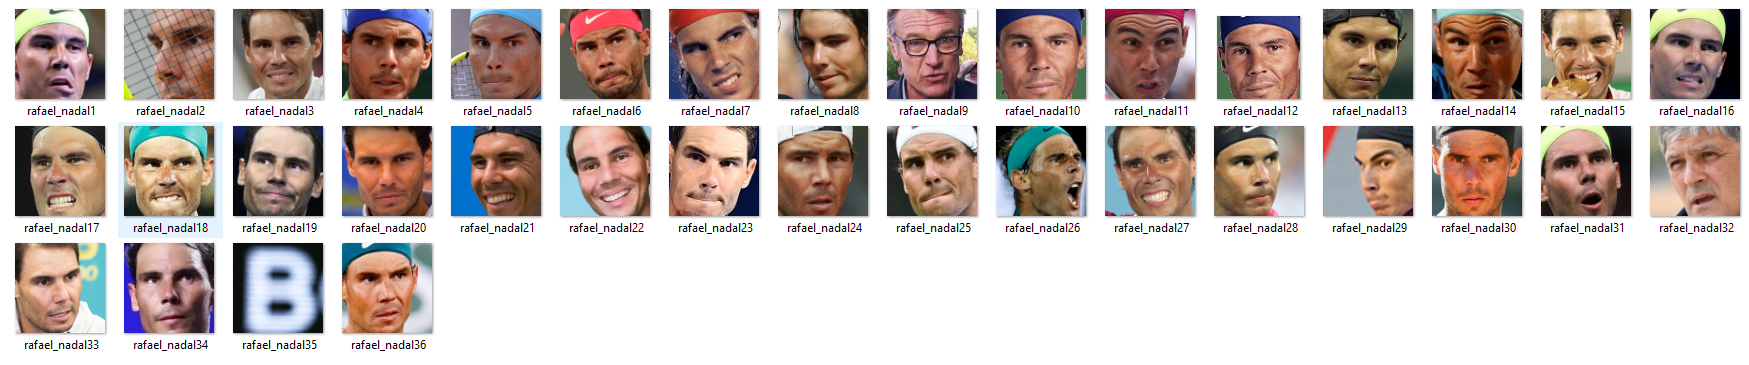

After deleting incorrect crops, we had our data ready to develop the model.

**Model**

To generate a classifier, it was necessary to identify a way to extract features, I came a across a technique called wavelet transformation. This will allow the model to extract important features from the images.

In [343]:
# Code example from stack overflow
def w2d(img, mode='haar', level=1):
    imArray = img
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    imArray =  np.float32(imArray)   
    imArray /= 255;
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

Example of wavelet transformation and what it does to an image. This allows to extract important features in black and white, in face detection is complicated to identify shades and colors, so I opted to implement this approach.

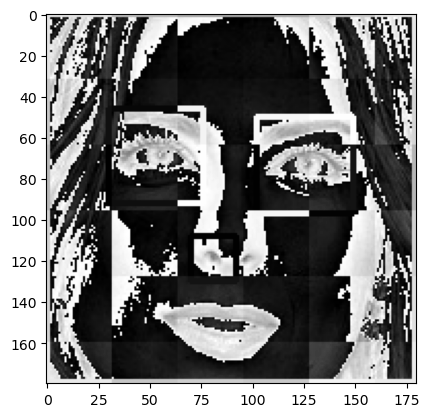

In [344]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

Appending Images

In [307]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'maria_sharapova': ['./dataset/cropped/maria_sharapova\\maria_sharapova10.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova11.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova12.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova13.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova15.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova16.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova17.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova18.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova19.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova2.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova20.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova21.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova23.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova24.png',
  './dataset/cropped/maria_sharapova\\maria_sharapova25.png',
  './dataset/cropped/maria_sharapova\\maria_sharapov

Assigning labels for each one of the athletes.

In [360]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'maria_sharapova': 0,
 'novak_djokovic': 1,
 'rafael_nadal': 2,
 'roger_federer': 3,
 'serena_williams': 4}

Iterating through the folders containing the images. Then for each image we will read it using `opencv`, scaling the size (32,32), wavelet transformation in same dimensions, and then vertically stack them so we can create the X and Y vectors.

In [361]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  

In [365]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

array([[182., 182., 182., ..., 188.,  48.,  46.],
       [ 14.,  14.,  14., ...,   4.,   7.,   2.],
       [240., 219., 192., ..., 173., 233.,   8.],
       ...,
       [ 64.,  44.,  37., ...,   4.,   2., 252.],
       [ 82., 101., 136., ...,   0.,   1.,   0.],
       [ 49.,  49.,  55., ..., 196.,  11., 212.]])

In [363]:
X[0] # Numbers that represent a particular feature of the image

array([182., 182., 182., ..., 188.,  48.,  46.])

**Splitting the Data and Model Training**

In [364]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [356]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))]) # Random parameters
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test) # Checking how good the model is performing. 

0.5833333333333334

In [354]:
len(X_test) #Tested on 36 images and obtained an accuracy of 58%

36

In [355]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      0.36      0.44        11
           1       0.67      1.00      0.80         8
           2       0.47      0.88      0.61         8
           3       1.00      0.25      0.40         8
           4       0.00      0.00      0.00         1

    accuracy                           0.58        36
   macro avg       0.54      0.50      0.45        36
weighted avg       0.65      0.58      0.54        36



C:\Users\Owner\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Using Grid Search to tune Hyperparameters and try alternative models.

In [315]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    }
}

In [357]:
# Cross Validation
scores = []
best_estimators = {}
for alg, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': alg,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[alg] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df


model  best_score                                   best_params
0            svm    0.609524        {'svc__C': 1, 'svc__kernel': 'linear'}
1  random_forest    0.542857  {'randomforestclassifier__n_estimators': 10}

In [319]:
# Best parameters in test sets
best_estimators['svm'].score(X_test,y_test)

0.6388888888888888

In [321]:
best_clf = best_estimators['svm']

In [323]:
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[9, 0, 2, 0, 0],
       [0, 7, 0, 1, 0],
       [1, 0, 5, 2, 0],
       [1, 3, 2, 2, 0],
       [0, 0, 1, 0, 0]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

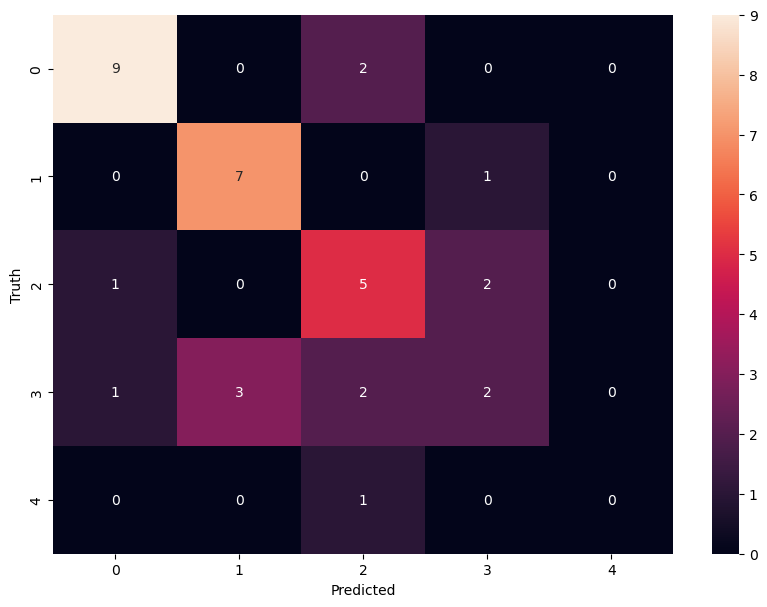

In [324]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [358]:
class_dict

{'maria_sharapova': 0,
 'novak_djokovic': 1,
 'rafael_nadal': 2,
 'roger_federer': 3,
 'serena_williams': 4}